# A Neural Algorithm of Artistic Style

这篇文章是图片风格迁移的第一篇文章，文章大部分内容都在讲废话，凑字数，真正有价值的内容其实并不多。**核心思想就是将 Content 图片 和 Style 图片过一遍 Convolutional Neural Network，取其中特定几层的输出，然后用定义出的 Content Loss 和 Style Loss，在新的图片上进行优化**.这个方法可以实现图像风格的迁移，但是实际的体验下来实在是太慢了，在 GPU 的环境下，300 个 Epoche 也需要 28s 渲染一张图片。这个 notebook 是结合 Pytorch 的 [官方例子](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=neural%20transfer) 对原始论文的一种解读。

## 环境准备

根据机器上的 CUDA 版本，安装对应 Pytroch 就好，我的机器是 Ubuntu 18.04， Cuda 10.2 所以根据 [官方链接](https://pytorch.org/get-started/locally/)，我选择安装 10.1 版本的 Pytorch：

```
    conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
```

Convolutional Nerual Network 的每一层的输出单元，可以看作是抽取图片上某一部分特征的功能单元。如果解决的问题是图像识别，Neural Network 每一层做的事情就是在前一层的基础上对原始数据进行表示，这样随着处理层次的加深，相应层次就变的更关注图片的内容及内容在图片上所处的为位置而不是图片上具体的每一个像素的值，并且在高层次上，并不会限制具体的像素的值。相应的，在 Neural Network 的较低层级，这些层级就是简单的从原始图片中提取像素值。

所以 Convolutional Nerual Netowrk 在这个任务上高的层次用来提取 Content 和 Content 的位置信息，较低的层级来提取 Style 信息。具体的，这篇文章使用 VGG19 的 ‘Conv4_2’ 抽取内容特征，使用 ‘Conv1_1’, ‘Conv2_1’, ‘Conv3_1’, ‘Conv4_1’, ‘Conv5_1’ 抽取风格的特征。

## Methods


In [1]:
# import essential package

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import copy
import os

In [2]:
# get environment infomation

# working directory
BASEDIR = os.getcwd()
print(BASEDIR)

# run on which device, gpu or cpu
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

/home/hailingu/Git/MLFM
cuda


In [3]:
# define image location
CONTENT_IAMGE_PATH = BASEDIR + '/assets/images/view.jpg'
STYLE_IMAGE_PATH = BASEDIR + '/assets/images/picasso.jpg'

# define image size
IMAGE_H = 350
IMAGE_W = 400

现在一些基本信息准备好了，下一步要做的就是加载图片并把它转换成 Pytroch 的 Tensor。同时定义了一个函数将 Tensor 转换成图片。

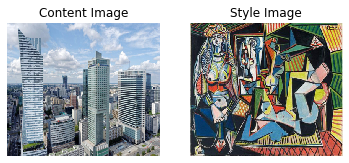

In [4]:
image_transformer = transforms.Compose([transforms.Resize([IMAGE_H, IMAGE_W]), transforms.ToTensor()])
image_reverse_transformer = transforms.ToPILImage()


# image loader
def image_loader(path):
    image = Image.open(path)
    image = image_transformer(image).unsqueeze(0) # unsqueeze will add an dimension in PyTorch tensor at index 0. e.g.: [c, h, w] after unsqueeze(0) -> [n, c, h, w]. n means the number of pictures 
    return image.to(device, torch.float)


# image unloader
def image_unloader(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = image_reverse_transformer(image)
    return image


style_image = image_loader(STYLE_IMAGE_PATH)
content_image = image_loader(CONTENT_IAMGE_PATH)

assert style_image.size() == content_image.size(), 'we need to import style and content images of the same size'


# show picture
plt.figure()

pic_axis = plt.subplot(1, 2, 1)
pic_axis.set_title('Content Image')
pic_axis.axis('off')
plt.imshow(image_unloader(content_image))

pic_axis = plt.subplot(1, 2, 2)
pic_axis.set_title('Style Image')
pic_axis.axis('off')
plt.imshow(image_unloader(style_image))

plt.show()

Content 的损失函数定义成 Content 抽取层抽出的特征，与输入白噪声的图片在相应层计算出特征的 MSE 损失。计算的时候要对输入的 Content 图片 在这层抽取后的 tensor 进行 detach 操作，因为它不需要进行优化。

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    
    def forward(self, input_tensor):
        self.loss = F.mse_loss(input_tensor, self.target)
        return input_tensor

Style 的损失函数定义成了 Style 抽取层抽取的特征，与输入白噪声的图片在该层计算出特征，分别构造出对应的 Gram 矩阵，然后比较两个 Gram 矩阵就可以衡量相似性。比较的过程可以通过白噪声的 Gram 矩阵与 Style 输入的 Gram 矩阵对应元素值，使用 MSE 进行计算。

对于 Style 图片，在第 l 层的 Gram 矩阵被定义成： $A^l_{ij}=\sum_kF^l_iF^l_j$。

Gram 矩阵之所以能表示纹理，简单的理解可以是，如果第 l 层有 N 个抽取出来的特征 F，每一个特征的维度是 k，那么任意两个特征 $F_i$ 和 $F_j$之间的空间信息，可以通过两个向量的余弦来表达，即 $cos(F_i, F_j)=\frac{F_i \cdot F_j}{||F_i|| \cdot ||F_j||}$，由于 Gram 表达的是空间信息，所以对比白噪声提取出的 Style 和 目标 Style 的结果就是空间信息大致一致，也即风格。

In [6]:
def gram_matrix(input_tensor):
    n, f, h, w = input_tensor.size()
    features = input_tensor.view(n * f, h * w)
    G = torch.mm(features, features.t())
    return G


class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.loss = None
        self.A = gram_matrix(target).detach()
        n, f, h, w = target.size()
        self.N = f
        self.M = h * w
    
    def forward(self, input_tensor):
        G = gram_matrix(input_tensor)
        self.loss = (F.mse_loss(G, self.A)) / (4 * self.N**2 * self.M**2)
        return input_tensor

两个损失都定义好了之后，就需要 vgg19 抽取出相应的层的输出，把预训练的 vgg19 从 PyTorch 中取出来，由于不需要再次训练 vgg19,所以需要把模型置为 eval。在抽取层的时候，首先要找到对应的层。在与训练的 vgg19 网络输入的时候，需要对输入进行标准化，也即 z-score 对每一个通道上的数值进行标准化。

In [7]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input_tensor):
        return (input_tensor - self.mean) / self.std

In [8]:
vgg19_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg19_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

normalization = Normalization(vgg19_normalization_mean, vgg19_normalization_std)

In [9]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

def get_style_model_and_losses(cnn, normaliaztion, content_image, style_image, content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normaliaztion)

    i = 1
    sub_i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            sub_i += 1
            name = 'conv{}_{}'.format(i, sub_i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(i, sub_i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'maxpool{}_{}'.format(i, sub_i)
            i += 1
            sub_i = 0
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(layer, sub_i)
        else:
            raise RuntimeError('Unrecogonized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss{}_{}'.format(i, sub_i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_image).detach()
            style_loss = StyleLoss(target)
            model.add_module('style_loss{}_{}'.format(i, sub_i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

制造一张白噪声图片

In [10]:
n, f, h, w = content_image.size()
input_image = torch.randn(n * f * h * w).to(device)
input_image = input_image.reshape(n, f, h, w)
input_image = content_image.clone() + input_image

assert input_image.size() == content_image.size(), 'we need to import input and content images of the same size'

In [11]:
def get_input_optimizer(input_tensor):
    optimizer = optim.LBFGS([input_tensor.requires_grad_()])
    return optimizer

真正的开始风格迁移

In [12]:
def run_style_transfer(cnn, normalization, content_image, style_image, input_image, epochs=1000, style_weight=100000,
                       content_weight=1):
    content_layers = ['conv4_2']
    style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

    model, content_losses, style_losses = get_style_model_and_losses(cnn, normalization, content_image, style_image,
                                                                     content_layers, style_layers)

    optimizer = get_input_optimizer(input_image)

    print('Start style transfer..')

    run = [0]
    while run[0] <= epochs:

        def closure():
            input_image.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_image)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss

            for sl in style_losses:
                style_score += sl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}:'.format(run[0]))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score, content_score))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_image.data.clamp_(0, 1)
    return input_image



运行并输出风格迁移图片

Start style transfer..
run 50:
Style Loss: 137.262405 Content Loss: 133.116592

run 100:
Style Loss: 50.048031 Content Loss: 99.861633

run 150:
Style Loss: 36.008835 Content Loss: 85.655731

run 200:
Style Loss: 30.261526 Content Loss: 77.626129

run 250:
Style Loss: 28.669142 Content Loss: 72.152832

run 300:
Style Loss: 25.972809 Content Loss: 69.321289

run 350:
Style Loss: 24.948784 Content Loss: 66.908035

run 400:
Style Loss: 24.004068 Content Loss: 64.484375

run 450:
Style Loss: 23.497967 Content Loss: 62.954594

run 500:
Style Loss: 22.988222 Content Loss: 61.490635

run 550:
Style Loss: 22.596603 Content Loss: 60.340431

run 600:
Style Loss: 26.301315 Content Loss: 59.642849

run 650:
Style Loss: 28.178596 Content Loss: 58.122421

run 700:
Style Loss: 21.778208 Content Loss: 57.551617

run 750:
Style Loss: 85.975349 Content Loss: 69.260704

run 800:
Style Loss: 22.212000 Content Loss: 57.610771

run 850:
Style Loss: 21.225534 Content Loss: 55.465874

run 900:
Style Loss: 20.

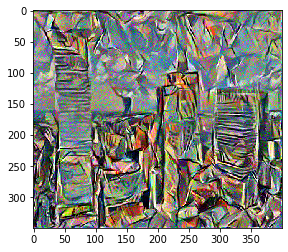

In [13]:
output = run_style_transfer(vgg19, normalization, content_image, style_image, input_image)
plt.figure()
plt.imshow(image_unloader(output))
plt.show()